In [107]:
import numpy as np
import pandas as pd
import math

from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [108]:
data = pd.read_csv('./data/adult.csv')

---

### Первичное исследование

In [109]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [110]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [111]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


---

### Проверка сбалансированности классов

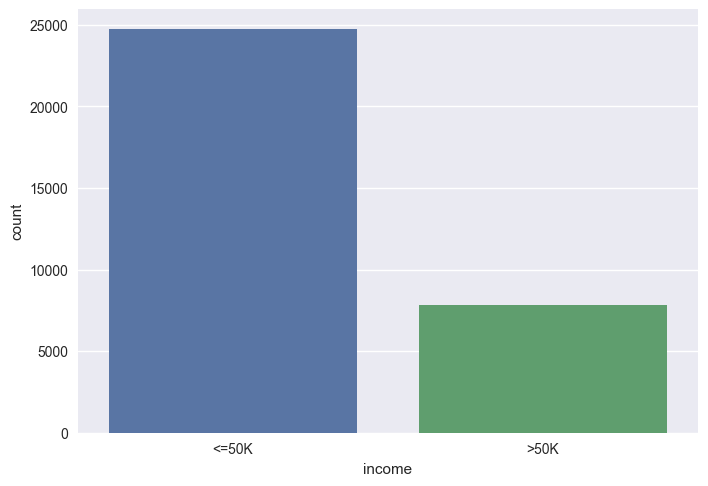

In [112]:
sns.countplot(data=data, x='income');

In [113]:
# Протзведем кодирование целевого признака
data['income'] = data['income'].apply(lambda x: 0 if x == '<=50K' else 1)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [114]:
# Исследуем категориальные и числовые признаки
types = data.dtypes
cat_types = list(types[(types == 'object')].index)
num_types = list(types[(types != 'object')].index)


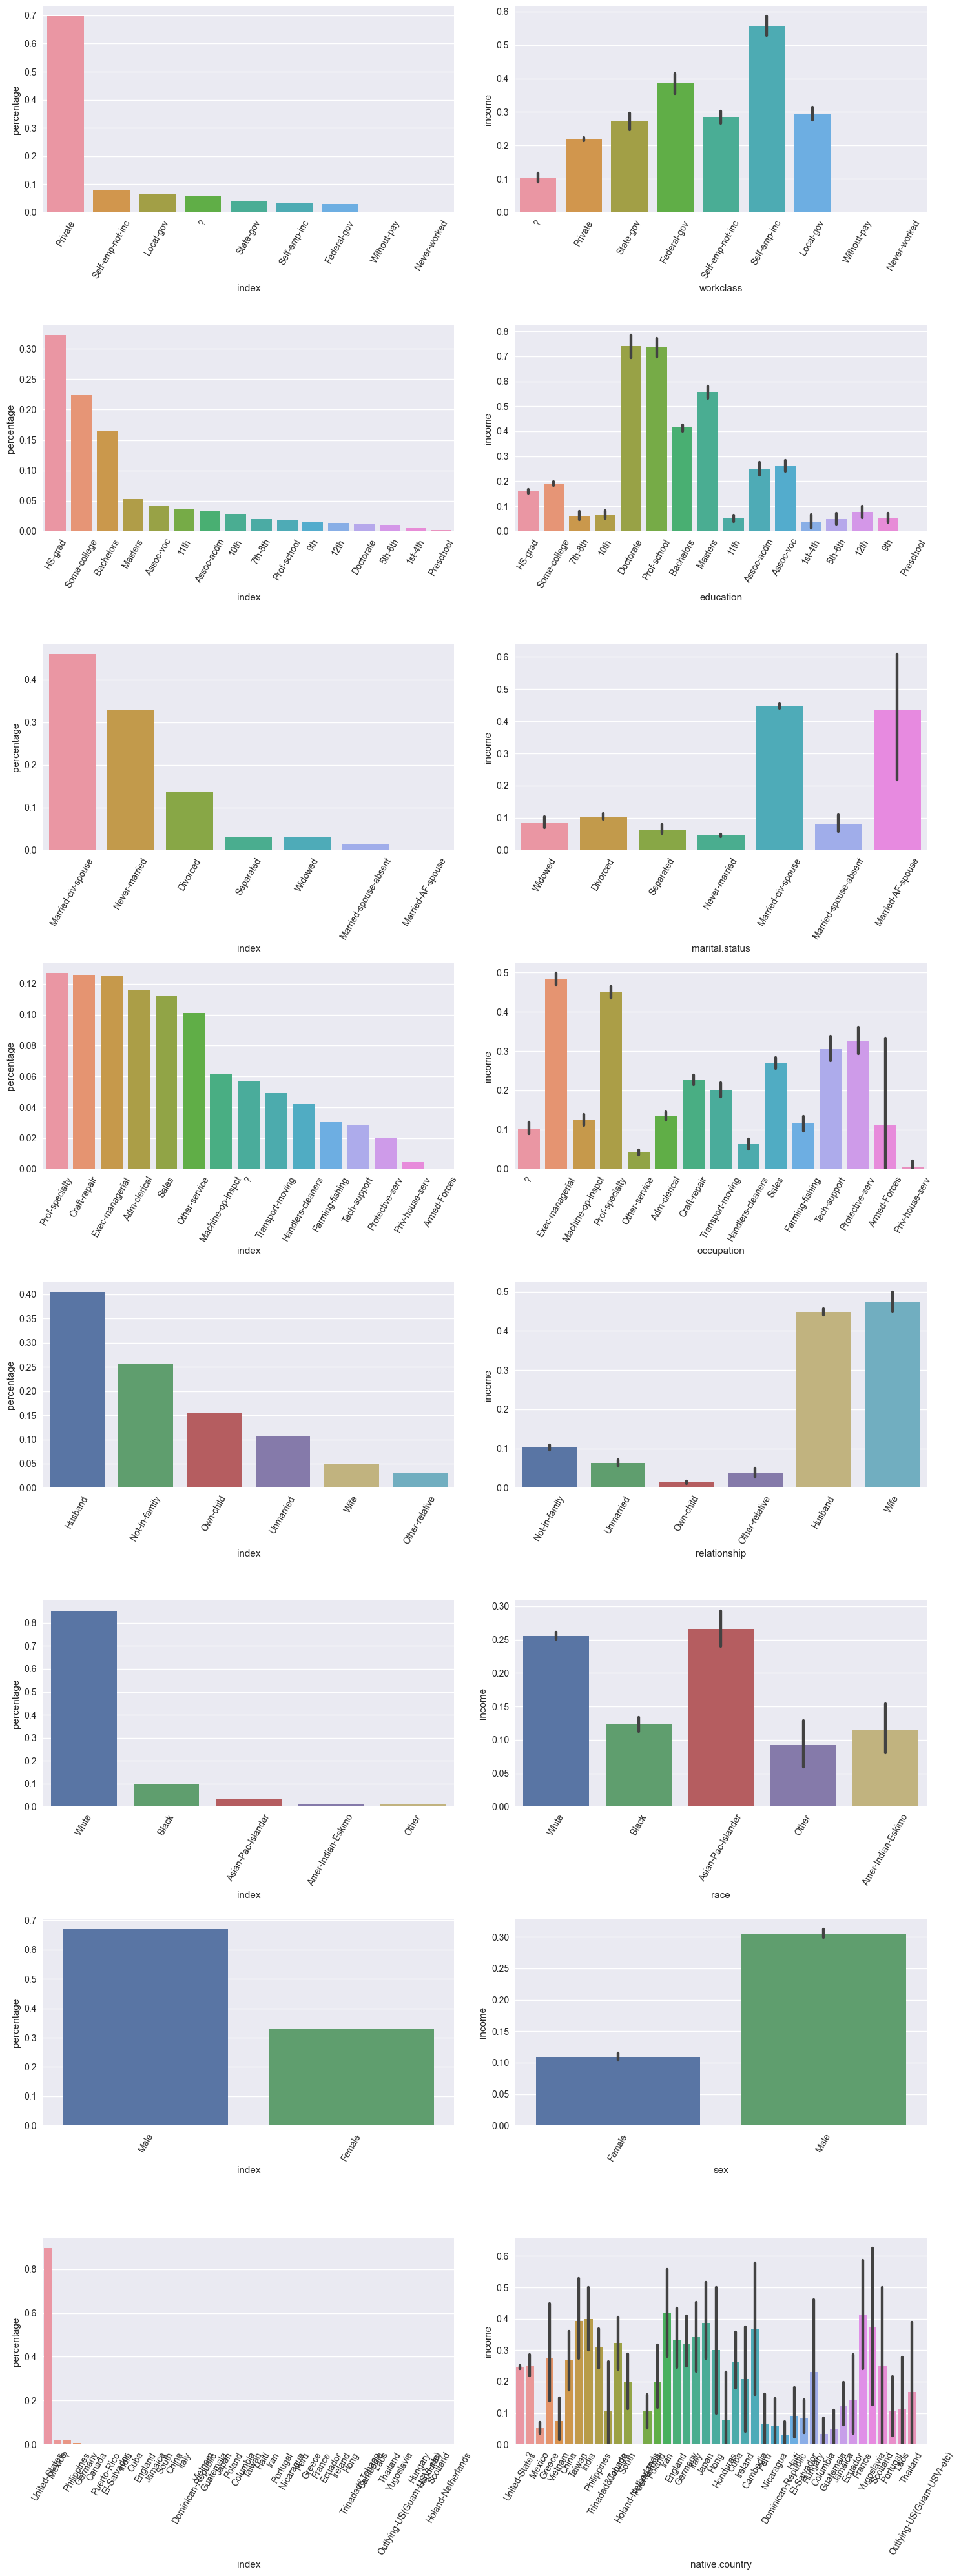

In [115]:
# Визуализируем категориальные признаки
n = len(cat_types)

fig, axes = plt.subplots(n, 2, figsize=(15, 40))

for i, element in enumerate(cat_types):
    count_data = (data[element].value_counts(normalize=True)
                    .sort_values(ascending=False)
                    .rename('percentage')
                    .reset_index())

    count_barplot = sns.barplot(
        data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)

    mean_barplot = sns.barplot(data=data, x=element, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)

plt.tight_layout()


---

### Проведем предобработку данных

In [116]:
data['native.country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

In [117]:
adult_data = data.copy()

In [118]:
# Сформируем категорию школьников
adult_data['education'] = adult_data['education'].apply(
    lambda x:
        'School' if x == '11th'
        or x == '10th'
        or x == '7th-8th'
        or x == '9th'
        or x == '12th'
        or x == '5th-6th'
        or x == '1st-4th'
        else x
)


In [119]:
# Сформируем категорию доцентов
adult_data['education'] = adult_data['education'].apply(
    lambda x:
        'Associate' if x == 'Assoc-voc'
        or x == 'Assoc-acdm'
        else x
)


In [120]:
# Создадим категорию одиночек в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x:
        'Prev_Married' if x == 'Divorced'
        or x == 'Separated'
        or x == 'Widowed'
        else x
)


In [121]:
# Создадим категорию женатых в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x:
        'Married' if x == 'Married-civ-spouse'
        or x == 'Married-spouse-absent'
        or x == 'Married-AF-spouse'
        else x
)


In [122]:
# Объединяем мужей и жен
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x:
        'In relationship' if x == 'Husband'
        or x == 'Wife'
        else 'Not in relationship'
)

In [123]:
# Объединяем типы занятости не приносящие доход
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Without-pay' or 
    x == 'Never-worked'
    else x
)

In [124]:
# Объединяем приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States'
    else x
)

In [125]:
# Прологорифмируем числовые признаки для придания им вида близкого к нормальному распределению
adult_data['capital.gain'] = np.log(adult_data['capital.gain'] +1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss'] +1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt'] +1)

In [126]:
# Расчитаем разницу между приростом капитала и его убылью
adult_data['capitall_diff'] = abs(adult_data['capital.gain'] - adult_data['capital.loss'])

In [127]:
adult_data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income', 'capitall_diff'],
      dtype='object')

In [128]:
# Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

In [129]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,17800,27816,21790,29170


/var/folders/1_/hgb3xg852md0hqqs3ybwbsp40000gn/T/ipykernel_53522/2067087370.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=adult_data.corr(), annot=True)


<AxesSubplot: >

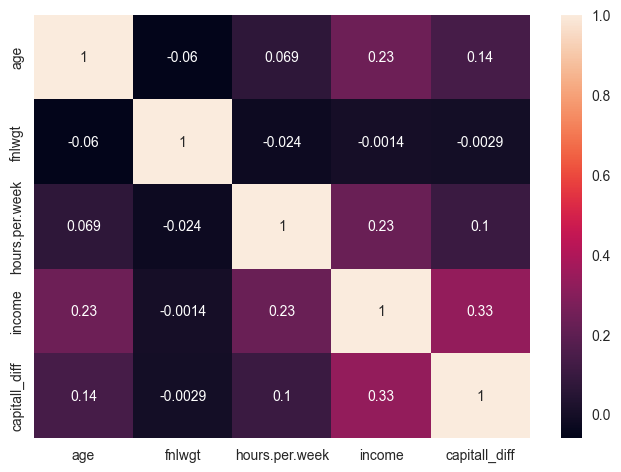

In [130]:
# Оцениваем мультиколлинеарность и зависимость с целевым признаком
sns.heatmap(data=adult_data.corr(), annot=True)

In [131]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)

In [132]:
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capitall_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


---

Создаем матрицу наблюдений Х и вектор правильных ответов у

In [133]:
X = dummies_data.drop('income', axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в пропорции 80/20, используем параметр stratify для работы с несбалансированными выборками

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)

Производим нормализацию данных

In [135]:
scaller = preprocessing.MinMaxScaler()
scaller.fit(X_train)

X_train_scaled = scaller.transform(X_train)
X_test_scaled = scaller.transform(X_test)

---

Моделируем

In [136]:
# Создаем объект класса логистической регрессии
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #обеспечиваем сходимость модели
    max_iter=1000 #колличество итераций на сходимость
)

# Обучаем модель
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

Выводим отчет по метрикам

In [137]:
y_train_pred = log_reg.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19775
           1       0.72      0.58      0.64      6273

    accuracy                           0.84     26048
   macro avg       0.80      0.75      0.77     26048
weighted avg       0.84      0.84      0.84     26048

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4945
           1       0.72      0.58      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.77      6513
weighted avg       0.84      0.85      0.84      6513



Подберем наимболее оптимальный вероятностный порог деления на группы (вероятностный классификатор)

In [138]:
# Считаем вероятности
y_test_proba_pred = log_reg.predict_proba(X_train_scaled)[:,1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
y_test_proba_pred

0        0.008117
1        0.232122
2        0.032131
3        0.009851
4        0.364839
           ...   
26043    0.060607
26044    0.010941
26045    0.120187
26046    0.013068
26047    0.021112
Length: 26048, dtype: float64

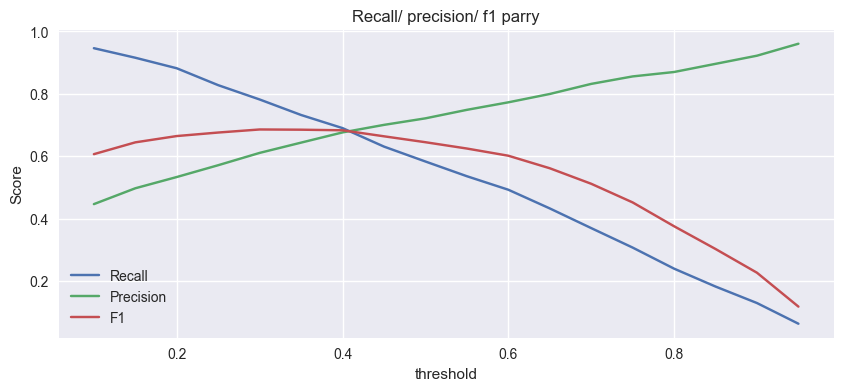

In [174]:
# Создадим списки для хранения метрик
recall_scores = []
precision_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1 с шагом 0.05
thresholds = np.arange(0.1, 1, 0.05)

# Пробегаем по пороговым значениям расчитывая полученные
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Считаем метрики и добавляем их в соответсвующие списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# Визуализируем
fig, axes = plt.subplots(figsize=(10, 4))

axes.plot(thresholds, recall_scores, label='Recall')
axes.plot(thresholds, precision_scores, label='Precision')
axes.plot(thresholds, f1_scores, label='F1')

axes.set_title('Recall/ precision/ f1 parry')
axes.set_xlabel('threshold')
axes.set_ylabel('Score')
axes.legend()
